In [168]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [169]:
import lightgbm as lgb
import optuna

import matplotlib.pyplot as plt
import seaborn as sns

import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, classification_report,
    ConfusionMatrixDisplay, confusion_matrix
)


# LightGBM 
## Why LightGBM ?
- LightGBM continues the Ensemble Learning method of XGBoost (the generation of weak classifications by optimizing the structured loss function, adding the regularization to reduce the risk of overfitting), but it pays more attention to
    - Training Speed: uses the **pre sorting** algorithm when looking for the best split point
    - Low Memory Usage

In [170]:
# train_df = pd.read_csv("/kaggle/input/titanic/train.csv").set_index("PassengerId")
# tests_df = pd.read_csv("/kaggle/input/titanic/test.csv").set_index("PassengerId")
train_df = pd.read_csv("/kaggle/input/titanic/train.csv").set_index("PassengerId").drop(["Name", "Ticket", "Cabin"], axis=1)
test_df = pd.read_csv("/kaggle/input/titanic/test.csv").set_index("PassengerId").drop(["Name", "Ticket", "Cabin"], axis=1)

In [171]:
# Create a new feature: FamilySize = SibSp + Parch + 1 (self included)
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

In [172]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,2
2,1,1,female,38.0,1,0,71.2833,C,2
3,1,3,female,26.0,0,0,7.9250,S,1
4,1,1,female,35.0,1,0,53.1000,S,2
5,0,3,male,35.0,0,0,8.0500,S,1


In [173]:
def preprocess_data(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    # Convert categorical columns to 'category' dtype as required by lgb.Dataset
    for col in cat_features:
        X[col] = X[col].astype("category")
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
    
    lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features, free_raw_data=False)
    lgb_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features, free_raw_data=False, reference=lgb_train)
    
    return lgb_train, lgb_valid, X_valid, y_valid

In [174]:
# Compute class imbalance ratio
pos_weight = (train_df["Survived"] == 0).sum() / (train_df["Survived"] == 1).sum()
print(f"scale_pos_weight: {pos_weight:.2f}")

def objective(trial, lgb_train, lgb_valid, X_valid, y_valid):
    params = {
        'objective': 'binary',
        'metric': 'average_precision',  # Use PR-AUC instead of AUC
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True), #log_uniform
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 200),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.0, 1.0),
        "scale_pos_weight": pos_weight,  # Adjust class imbalance
    }
    model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_valid])
    preds = model.predict(X_valid)
    # Compute PR-AUC
    pr_auc = average_precision_score(y_valid, preds)
    return pr_auc

def train_model():
    target_col="Survived" 
    lgb_train, lgb_valid, X_valid, y_valid = preprocess_data(train_df, target_col)
    
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, lgb_train, lgb_valid, X_valid, y_valid), n_trials=50)
    
    print("Best Parameters:", study.best_params)
    best_model = lgb.train(study.best_params, lgb_train, valid_sets=[lgb_train, lgb_valid])
    pred_proba = best_model.predict(X_valid)
    preds = (pred_proba > 0.5).astype(int)
    print("Accuracy:", accuracy_score(y_valid, preds))
    print("AUC Score:", roc_auc_score(y_valid, pred_proba))
    print(f"PR AUC Score: {average_precision_score(y_valid, pred_proba)}")
    print(classification_report(y_valid, preds))
    return best_model, X_valid, y_valid
best_model, X_valid, y_valid = train_model()

[I 2025-03-26 17:19:22,721] A new study created in memory with name: no-name-c0ed612c-9bc2-4df0-b9b4-fcdebb5e19cd
[I 2025-03-26 17:19:22,764] Trial 0 finished with value: 0.8466106360461038 and parameters: {'learning_rate': 0.2594405651638522, 'num_leaves': 78, 'max_depth': 10, 'min_data_in_leaf': 48, 'feature_fraction': 0.5260516763269497, 'bagging_fraction': 0.4945510641553936, 'bagging_freq': 9, 'lambda_l1': 0.0003962478276800835, 'lambda_l2': 0.0020168001626931363, 'min_gain_to_split': 0.7080744046933907}. Best is trial 0 with value: 0.8466106360461038.
[I 2025-03-26 17:19:22,797] Trial 1 finished with value: 0.8660296333226792 and parameters: {'learning_rate': 0.22258940455949677, 'num_leaves': 98, 'max_depth': 7, 'min_data_in_leaf': 108, 'feature_fraction': 0.7877411885481951, 'bagging_fraction': 0.6561736325170335, 'bagging_freq': 5, 'lambda_l1': 7.445465918528828e-06, 'lambda_l2': 0.009617809138722724, 'min_gain_to_split': 0.8700381848705027}. Best is trial 1 with value: 0.8660

scale_pos_weight: 1.61


[I 2025-03-26 17:19:22,940] Trial 5 finished with value: 0.8180914777073426 and parameters: {'learning_rate': 0.21481383039903415, 'num_leaves': 82, 'max_depth': 12, 'min_data_in_leaf': 133, 'feature_fraction': 0.5672817469084709, 'bagging_fraction': 0.5450636641827677, 'bagging_freq': 3, 'lambda_l1': 7.515709831505467, 'lambda_l2': 4.520952850817078e-08, 'min_gain_to_split': 0.5521167562174304}. Best is trial 1 with value: 0.8660296333226792.
[I 2025-03-26 17:19:23,016] Trial 6 finished with value: 0.8659710974658208 and parameters: {'learning_rate': 0.01326837321108284, 'num_leaves': 255, 'max_depth': 12, 'min_data_in_leaf': 24, 'feature_fraction': 0.7029485002058569, 'bagging_fraction': 0.7870442229389449, 'bagging_freq': 4, 'lambda_l1': 0.0005215323336477116, 'lambda_l2': 1.008089076747967, 'min_gain_to_split': 0.3166925142198934}. Best is trial 1 with value: 0.8660296333226792.
[I 2025-03-26 17:19:23,073] Trial 7 finished with value: 0.849139131465695 and parameters: {'learning_ra

Best Parameters: {'learning_rate': 0.08918394314513024, 'num_leaves': 20, 'max_depth': 6, 'min_data_in_leaf': 15, 'feature_fraction': 0.8512444081443297, 'bagging_fraction': 0.6585581707738749, 'bagging_freq': 5, 'lambda_l1': 3.32273364306496e-05, 'lambda_l2': 1.5120206022706417e-05, 'min_gain_to_split': 0.9792574437157225}
Accuracy: 0.7988826815642458
AUC Score: 0.8776705276705277
PR AUC Score: 0.8398463950696693
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       105
           1       0.80      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


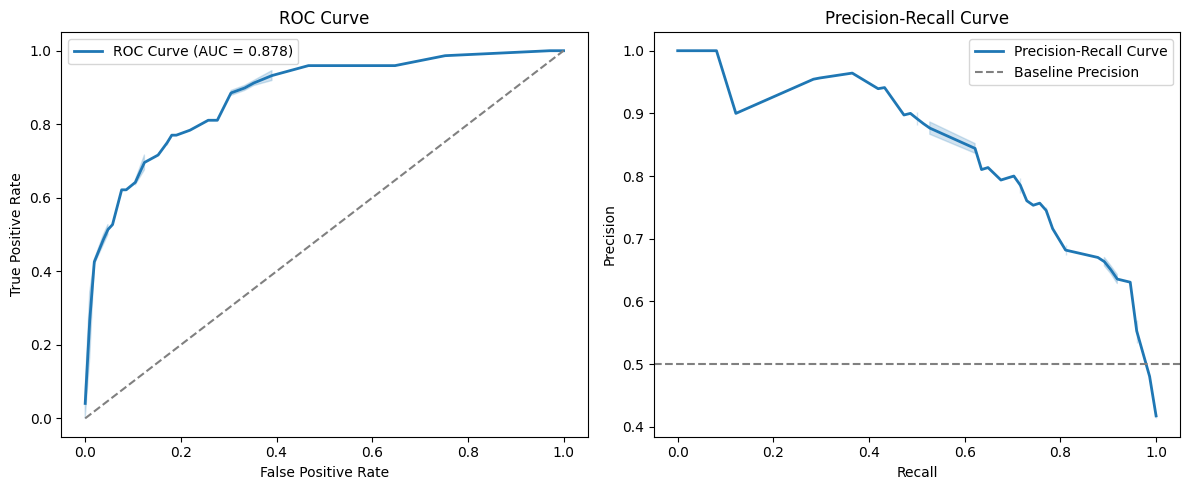

Best threshold based on F1-score: 0.278


In [175]:


def plot_roc_pr_curves(y_true, y_probs):
    """
    Plots ROC-AUC and Precision-Recall curves side by side.
    
    Parameters:
    - y_true: Actual target labels (0 or 1)
    - y_probs: Predicted probabilities for the positive class
    """
    # Compute ROC Curve & AUC
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    # Compute Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)  # Avoid division by zero
    best_threshold = thresholds[np.argmax(f1_scores)]

    # Create subplots (side by side)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # 🔹 ROC Curve
    sns.lineplot(x=fpr, y=tpr, ax=axes[0], label=f'ROC Curve (AUC = {roc_auc:.3f})', lw=2)
    axes[0].plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random chance line
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].set_title("ROC Curve")
    axes[0].legend()

    # 🔹 Precision-Recall Curve
    sns.lineplot(x=recall, y=precision, ax=axes[1], label="Precision-Recall Curve", lw=2)
    axes[1].axhline(y=0.5, color="gray", linestyle="--", label="Baseline Precision")  # Baseline
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_title("Precision-Recall Curve")
    axes[1].legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

    print(f"Best threshold based on F1-score: {best_threshold:.3f}")
    return best_threshold  # Return for further use

# Compute probability predictions
y_probs = best_model.predict(X_valid)

# Call function to plot ROC & PR Curves
best_threshold = plot_roc_pr_curves(y_valid, y_probs)

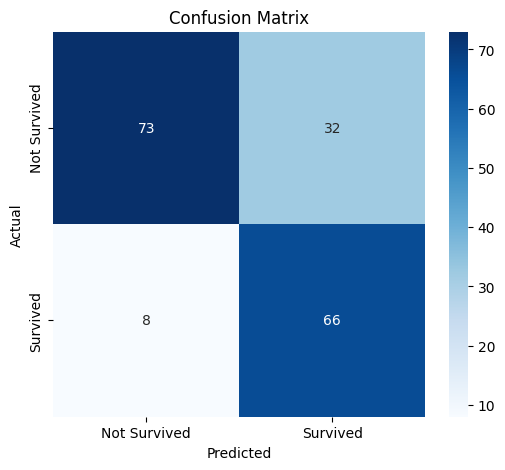

In [176]:
# Convert probabilities to predictions using the best threshold
y_pred_best = (y_probs >= best_threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_valid, y_pred_best)

# Plot confusion matrix with seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Survived", "Survived"], yticklabels=["Not Survived", "Survived"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [177]:
def create_cumulative_gain_table(y_true, y_probs):
    """
    Create a gain table with cumulative gain and lift analysis.
    
    Parameters:
    - y_true: Actual target labels (0 or 1)
    - y_probs: Predicted probabilities for the positive class

    Returns:
    - gain_table: DataFrame with cumulative gain and lift values
    """
    # Create DataFrame
    df = pd.DataFrame({'actual': y_true, 'predicted_prob': y_probs})

    # Sort by predicted probability in descending order
    df = df.sort_values(by="predicted_prob", ascending=False).reset_index()

    # Create deciles
    df["decile"] = pd.qcut(df["predicted_prob"], q=10, labels=np.arange(10, 0, -1))

    # Compute aggregated statistics
    gain_table = df.groupby("decile").agg(
        total_samples=("actual", "count"),
        actual_positives=("actual", "sum"),
        min_score=("predicted_prob", "min"),
        max_score=("predicted_prob", "max"),
        mean_score=("predicted_prob", "mean")
    ).reset_index()

    # Compute positive rate per decile
    gain_table["positive_rate"] = gain_table["actual_positives"] / gain_table["total_samples"]

    # Compute cumulative gain
    gain_table["cumulative_positives"] = gain_table["actual_positives"].cumsum()
    gain_table["cumulative_gain"] = gain_table["cumulative_positives"] / gain_table["actual_positives"].sum()

    # Compute lift (how much better the model is compared to random guessing)
    overall_positive_rate = gain_table["actual_positives"].sum() / gain_table["total_samples"].sum()
    gain_table["lift"] = gain_table["positive_rate"] / overall_positive_rate

    return gain_table

# Compute enhanced gain table
gain_table = create_cumulative_gain_table(y_valid, y_probs)

# Compute gain table
gain_table = create_cumulative_gain_table(y_valid, y_probs)
gain_table.head(10)


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,decile,total_samples,actual_positives,min_score,max_score,mean_score,positive_rate,cumulative_positives,cumulative_gain,lift
0,10,27,1,0.144084,0.156539,0.155422,0.037037,1,0.013514,0.089590
1,9,13,2,0.163756,0.163756,0.163756,0.153846,3,0.040541,0.372141
2,8,14,0,0.169262,0.179414,0.173097,0.000000,3,0.040541,0.000000
3,7,18,3,0.182064,0.220429,0.198439,0.166667,6,0.081081,0.403153
4,6,18,8,0.220778,0.285188,0.261879,0.444444,14,0.189189,1.075075
5,5,18,6,0.289238,0.338085,0.314394,0.333333,20,0.270270,0.806306
6,4,17,8,0.345303,0.552054,0.469716,0.470588,28,0.378378,1.138315
7,3,20,14,0.564852,0.775112,0.633279,0.700000,42,0.567568,1.693243
8,2,24,23,0.819822,0.867884,0.853418,0.958333,65,0.878378,2.318131
9,1,10,9,0.872563,0.893475,0.885111,0.900000,74,1.000000,2.177027


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


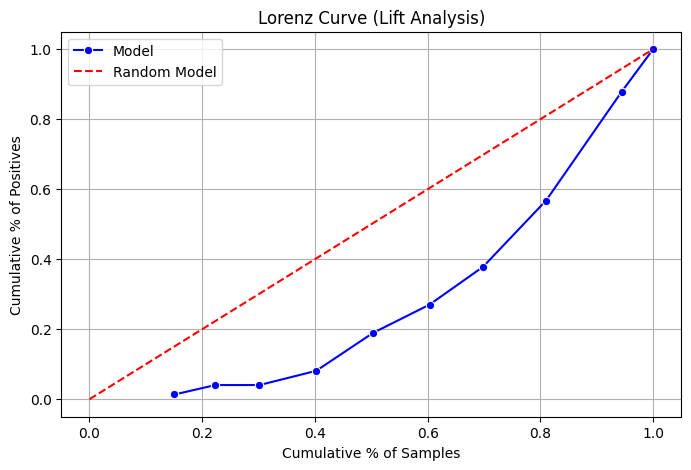

In [178]:
def plot_lorenz_curve(gain_table):
    """
    Plots the Lorenz curve to visualize lift analysis.
    """
    plt.figure(figsize=(8, 5))
    
    # Cumulative % of samples
    gain_table["cumulative_samples"] = gain_table["total_samples"].cumsum() / gain_table["total_samples"].sum()
    
    # Plot Lorenz curve
    sns.lineplot(x=gain_table["cumulative_samples"], y=gain_table["cumulative_gain"], marker="o", label="Model", color="blue")
    
    # Random guess line
    plt.plot([0, 1], [0, 1], linestyle="dashed", color="red", label="Random Model")
    
    plt.xlabel("Cumulative % of Samples")
    plt.ylabel("Cumulative % of Positives")
    plt.title("Lorenz Curve (Lift Analysis)")
    plt.legend()
    plt.grid()
    plt.show()

# Plot Lorenz curve
plot_lorenz_curve(gain_table)


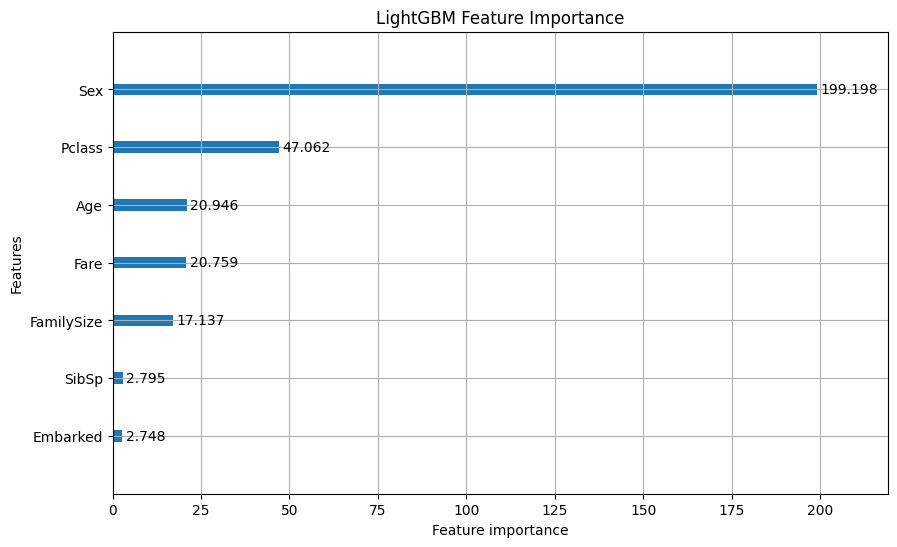

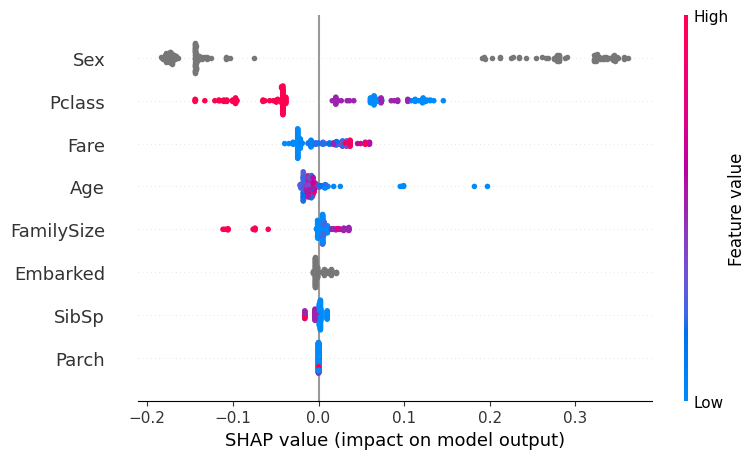

In [179]:
# 🎯 **Feature Importance**
lgb.plot_importance(best_model, importance_type='gain', figsize=(10, 6))
plt.title("LightGBM Feature Importance")
plt.show()

# 🎯 **SHAP Explanation**
explainer = shap.Explainer(best_model)
shap_values = explainer(X_valid)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_valid)

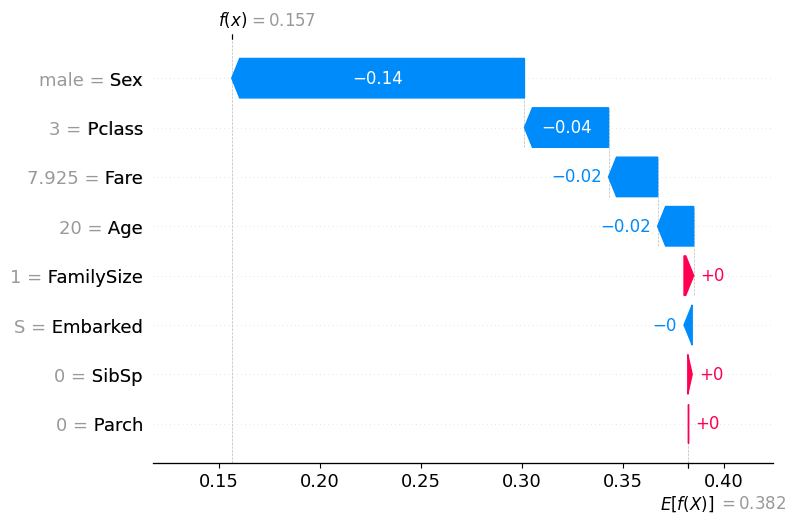

In [180]:
# Show SHAP values for a specific record (e.g., first record)
record_index = 2  # Change this to check other records
shap.waterfall_plot(shap_values[record_index])

In [181]:
# Convert SHAP values to a DataFrame
shap_df = pd.DataFrame(shap_values.values, columns=X_valid.columns)
# Combine feature values, SHAP values, and X_valid (X_valid need to reset the index as SHAP values are starting from index=0)
shap_all_df = pd.concat([X_valid.reset_index(), shap_df], axis=1)
shap_all_df.head()
# Add model predictions
shap_all_df["Prediction"] = best_model.predict(X_valid)

# Display the final SHAP DataFrame
shap_all_df.head()

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Prediction
0,710,3,male,NaN,1,1,15.2458,C,3,-0.049360,-0.130598,-0.020178,-0.003440,0.0,-0.000135,0.020102,0.016061,0.214709
1,440,2,male,31.0,0,0,10.5000,S,1,0.020165,-0.177890,-0.015526,0.001053,0.0,-0.008792,-0.004026,-0.001068,0.196174
2,841,3,male,20.0,0,0,7.9250,S,1,-0.041609,-0.144873,-0.017867,0.002169,0.0,-0.024296,-0.004038,0.004796,0.156539
3,721,2,female,6.0,0,1,33.0000,S,2,0.088366,0.274503,0.095427,0.002569,0.0,0.017857,-0.001612,0.005141,0.864509
4,40,3,female,14.0,1,0,11.2417,C,2,-0.106662,0.234321,0.007607,-0.016043,0.0,-0.009848,0.012298,0.011041,0.514971
